In [1]:
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import pandas as pd

In [2]:
from sympy import symbols, exp as sexp, diff, Derivative, Eq, solve, lambdify, solveset

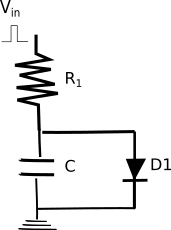

The object was to measure the voltage at the base of the transmitter (and later on at the base of R2) to determine the characteristics of the transistor.  Specifically to estimate the thermal coefficient $V_T$ and the scale current $I_{ES}$. The capacitor was to produce a comparatively slowly changing transistor base voltage with hopefully enough time for me to make measurements using an Arduino.  (This has since become slightly more complicated because the Arduino analog inputs have a time lag of 100 $\mu S$ which may add some measurement bias).

In [3]:
vcc, r, r1, r2, c, issym, vt, vin, vout, vbe, vc, t = symbols("V_{CC} R R1 R2 C I_{ES} V_T V_{in} V_{out} V_{BE} V_C t")

In [4]:
eqn1= Eq((vin - vc)/r1 - c * Derivative(vc,t) - issym*(sexp(vc/vt)-1),0)
eqn1

Eq(-C*Derivative(V_C, t) - I_{ES}*(exp(V_C/V_T) - 1) + (-V_C + V_{in})/R1, 0)

The above is a differential equation for the R1, C and base-emitter junction.  $V_C$ is the voltage across the capacitor.  Vin is a choice of 0 or 5 Volts as it is connected to one of the outputs of the Arduino digital pins.  By turning it on or off I was hoping to sweep through a range of voltages controlled by the time constand of R1 $\cdot$ C.  In my case R1 = 6K8 and C = $100 \mu F$.

It's basically a non linear differential equation which is impossible to solve using analytical methods.  Hence the attempt to solve it below using numerical methods.

Now I try to build my theoretical model using the equation above and some scientific libraries to integrate the equation to find what the solution would look like over time.
I am basically plotting the voltage across the capacitor as function of time.

In [5]:
vtval =  0.0321850033399526
isval = 1.602564611659814e-12

def model(t, y, vin, isval, vt):
    vcc=vin
    r=6800
    c=100e-6
    
    vc = y
    try:
        vcp =  (vcc-vc)/(r*c) - isval * (exp(vc/vt)-1) /(c)
    except OverflowError:
        #print (vc)
        return 1e20
    #print (vcp)
    return vcp
    
    

In [6]:
plt


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

Text(0.5, 1.0, 'Charging of $V_C$ over time(t)')

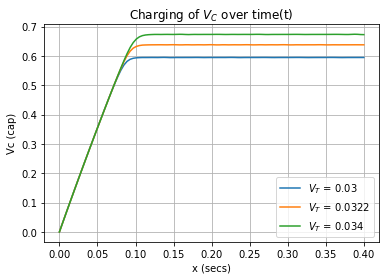

In [7]:
fig, ax = plt.subplots()
for vtvalue in (0.030, 0.0322, 0.034):
    teval = np.linspace(0, .4,100)
    res1 = solve_ivp(model, (0,.4), (0,),args=(5, 1.6e-12, vtvalue), t_eval = teval, first_step=0.001)

    ax.plot(res1.t,res1.y[0], label="$V_T$ = {}".format(vtvalue))

ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.legend()
ax.set_title("Charging of $V_C$ over time(t)")

Text(0.5, 1.0, 'Charging of $V_C$ over time(t)')

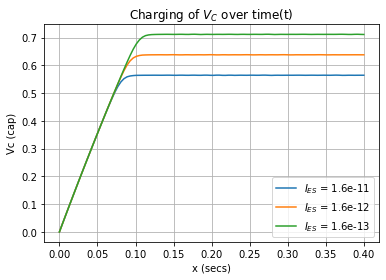

In [8]:
fig, ax = plt.subplots()
for isvalue in (1.6e-11, 1.6e-12, 1.6e-13):
    teval = np.linspace(0, .4,100)
    res1 = solve_ivp(model, (0,.4), (0,),args=(5, isvalue, 0.0322), t_eval = teval, first_step=0.001)

    ax.plot(res1.t,res1.y[0], label="$I_{{ES}}$ = {}".format(isvalue))

ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.legend()
ax.set_title("Charging of $V_C$ over time(t)")

In [9]:
teval = np.linspace(0, 1,100)
res2 = solve_ivp(model, (0,1), (.7,),args=(0,isval, vtval), t_eval = teval, first_step=0.001)

In [10]:
x = res2.t
y = res2.y[0]

Text(0.5, 1.0, 'Discharging of C over time(t)')

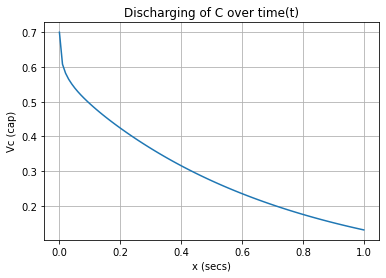

In [11]:
fig, ax = plt.subplots()

ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.set_title("Discharging of C over time(t)")

The results are unsurprising as the capacitor charges up to ( or discharges from ) 0.7 volts approximately.  Anything higher and the transistor conducts so the results are at least realistic.

Now I look at the results obtained from direct measurement via the Arduino analog input pin.

In [12]:
measurements = np.array([[ 0, 19, 0.09], 
[ 4, 24, 0.12], 
[ 8, 31, 0.15], 
[ 12, 36, 0.18], 
[ 16, 42, 0.21], 
[ 20, 49, 0.24], 
[ 24, 53, 0.26], 
[ 28, 58, 0.28], 
[ 32, 64, 0.31], 
[ 36, 69, 0.34], 
[ 40, 76, 0.37], 
[ 44, 80, 0.39], 
[ 48, 86, 0.42], 
[ 52, 92, 0.45], 
[ 56, 96, 0.47], 
[ 60, 101, 0.49], 
[ 65, 106, 0.52], 
[ 69, 112, 0.55], 
[ 73, 115, 0.56], 
[ 77, 119, 0.58], 
[ 81, 123, 0.60], 
[ 85, 125, 0.61], 
[ 89, 127, 0.62], 
[ 93, 129, 0.63], 
[ 97, 129, 0.63], 
[ 101, 130, 0.63], 
[ 105, 130, 0.63], 
[ 109, 131, 0.64], 
[ 113, 131, 0.64], 
[ 117, 131, 0.64], 
[ 121, 131, 0.64],
])

In [13]:
dfmeasure =  pd.DataFrame(measurements)
dfmeasure.columns = ['time', 'ADC', 'volts']
# ADC is the measure obtained from Arduino analogRead which returns a value from 0 to 1023.
# I divide that by 1024 and multiply by 5 to get a voltage.

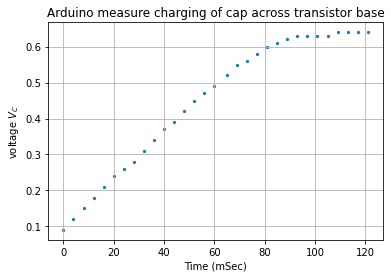

In [14]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure charging of cap across transistor base')


ax1 = dfmeasure.plot('time', 'volts', kind='scatter', marker=".", ax=ax)
ax1.set_xlabel('Time (mSec)')
ax1.set_ylabel('voltage $V_C$')


ax1.grid()

In [15]:
maxidx = np.argmax(res1.t>.120)

In [16]:
teval = np.linspace(0.001, .4,100)
res1 = solve_ivp(model, (0.001,.4), (0.09,),args=(5,isval, vtval), t_eval = teval, first_step=0.001)

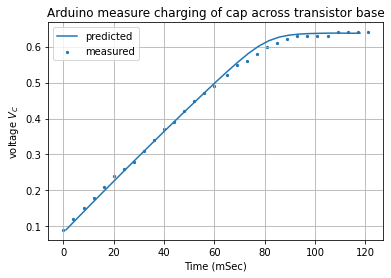

In [17]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure charging of cap across transistor base')


ax1 = dfmeasure.plot('time', 'volts', kind='scatter', marker=".", ax=ax, label="measured")
ax1.set_xlabel('Time (mSec)')
ax1.set_ylabel('voltage $V_C$')

x = (res1.t*1000)[0:maxidx]
y = res1.y[0][0:maxidx]
ax1.plot(x,y, label='predicted')
ax1.grid()
ax1.legend()

In [18]:
f=interp1d(dfmeasure['time'],dfmeasure['volts'], kind='linear', bounds_error=False, fill_value='extrapolate')

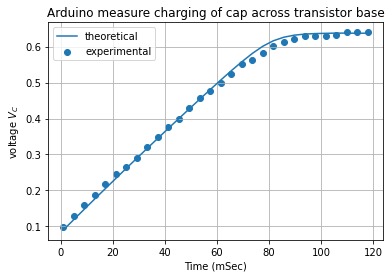

In [19]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure charging of cap across transistor base')



ax.set_xlabel('Time (mSec)')
ax.set_ylabel('voltage $V_C$')

x = (res1.t*1000)[0:maxidx]
y = res1.y[0][0:maxidx]
fy = f(x)
ax.plot(x,y, label='theoretical')
ax.scatter(x, fy, label='experimental')
ax.grid()
ax.legend()

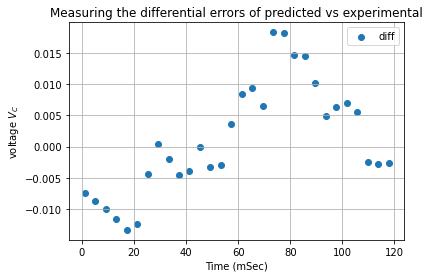

In [20]:
fig, ax = plt.subplots()

ax.set_title('Measuring the differential errors of predicted vs experimental')



ax.set_xlabel('Time (mSec)')
ax.set_ylabel('voltage $V_C$')

x = (res1.t*1000)[0:maxidx]
y = res1.y[0][0:maxidx]
fy = f(x)

ax.scatter(x, y-fy, label='diff')
ax.grid()
ax.legend()

In [21]:
eqn2 = solve(eqn1, Derivative(vc,t))[0]
eqn2

(I_{ES}*R1*(1 - exp(V_C/V_T)) - V_C + V_{in})/(C*R1)

In [22]:
e2 = eqn2.subs([(issym, 1.6e-12),(r1, 6800),(c,100e-6), (vin,5), (vt, .032)])
f2 = lambdify([vc],e2)

In [23]:
e2

-1.47058823529412*V_C - 1.6e-8*exp(31.25*V_C) + 7.35294119247059

In [24]:
f2(0)

7.35294117647059

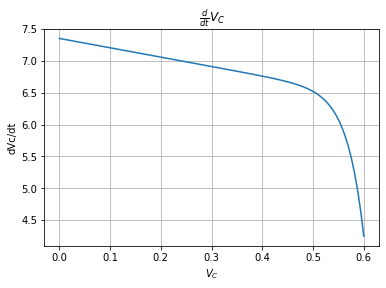

In [25]:
fig, ax = plt.subplots()

ax.set_title('$\\frac{d}{dt} V_C$')


ax1 = ax
ax1.set_ylabel('dVc/dt')
ax1.set_xlabel('$V_C$')

x = np.linspace(0, .6,100)
y = f2(x)
ax1.plot(x,y)
ax1.grid()

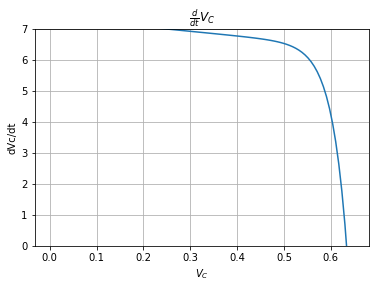

In [26]:
fig, ax = plt.subplots()

ax.set_title('$\\frac{d}{dt} V_C$')


ax1 = ax
ax1.set_ylabel('dVc/dt')
ax1.set_xlabel('$V_C$')

x = np.linspace(0, .65,100)
y = f2(x)
ax1.plot(x,y)
ax1.set_ylim(0,7)
ax1.grid()

In [27]:
symid = -eqn2.args[2].args[2]/r1
symrd = vc/symid
symrd

-V_C/(I_{ES}*(1 - exp(V_C/V_T)))

In [28]:
rdf=symrd.subs([(issym, 1.6e-12), (vt,0.0321)])

In [29]:
f3 = lambdify([vc],rdf)

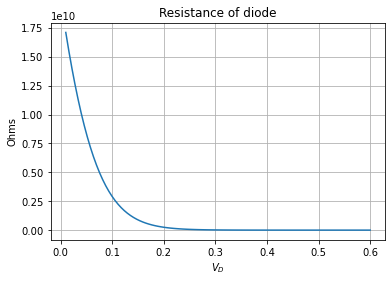

In [30]:
fig, ax = plt.subplots()

ax.set_title('Resistance of diode')


ax1 = ax
ax1.set_ylabel('Ohms')
ax1.set_xlabel('$V_D$')

x = np.linspace(0.01, .6,100)
y = f3(x)
ax1.plot(x,y)
ax1.grid()

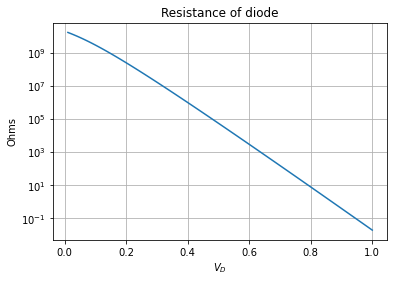

In [31]:
fig, ax = plt.subplots()

ax.set_title('Resistance of diode')


ax1 = ax
ax1.set_ylabel('Ohms')
ax1.set_xlabel('$V_D$')

x = np.linspace(0.01, 1,100)
y = f3(x)
ax1.semilogy(x,y)
ax1.grid()

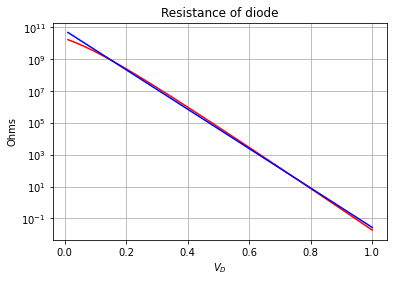

In [32]:
fig, ax = plt.subplots()

ax.set_title('Resistance of diode')

res = linregress(x, np.log(y))
slope = res.slope
intercept = res.intercept
def f4(x):
    y = np.exp(slope*x+intercept)
    return y
  
ax1 = ax
ax1.set_ylabel('Ohms')
ax1.set_xlabel('$V_D$')

x = np.linspace(0.01, 1,100)
y = f3(x)
ax1.semilogy(x,y, 'r-')
ax1.grid()
ax1.semilogy(x,f4(x),'b-')

In [33]:
res

LinregressResult(slope=-28.500520562252692, intercept=24.8915685536018, rvalue=-0.9993844511758467, pvalue=2.1050538631497554e-144, stderr=0.10106169422628397, intercept_stderr=0.05878542535863579)

In [34]:
eqn3 = Eq(symrd/(r + symrd), vc/vcc); eqn3

Eq(-V_C/(I_{ES}*(1 - exp(V_C/V_T))*(R - V_C/(I_{ES}*(1 - exp(V_C/V_T))))), V_C/V_{CC})

In [35]:
eqn4 = solve(eqn3, r)[0]; eqn4

-(V_C - V_{CC})/(I_{ES}*(exp(V_C/V_T) - 1))

In [36]:
rdf4=eqn4.subs([(issym, 1.6e-12), (vt,0.0321), (vcc,5)]); rdf4

-625000000000.0*(V_C - 5)/(exp(31.1526479750779*V_C) - 1)

In [37]:
f4 = lambdify([vc],rdf4)

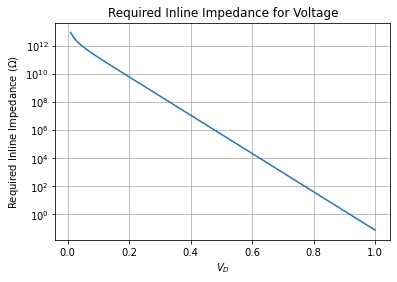

In [38]:
fig, ax = plt.subplots()

ax.set_title('Required Inline Impedance for Voltage')


ax1 = ax
ax1.set_ylabel('Required Inline Impedance ($\\Omega$)')
ax1.set_xlabel('$V_D$')

x = np.linspace(0.01, 1,100)
y = f4(x)
ax1.semilogy(x,y)
ax1.grid()

In [39]:
eqndiode = -eqn1.args[0].args[2]; eqndiode

I_{ES}*(exp(V_C/V_T) - 1)

In [40]:
eqn6 = vcc-r*eqndiode-vc; eqn6

-I_{ES}*R*(exp(V_C/V_T) - 1) - V_C + V_{CC}

In [41]:
f5def = (eqn6-vc).subs([(issym, isval),(vcc,5),])
f5 = lambdify([vc, vt,r],f5def)

In [42]:
f5(0.7, vtval, 6800)

-26.802408272819907

In [43]:
root_scalar(f5, args=(vtval,1000), bracket=(0,1))

      converged: True
           flag: 'converged'
 function_calls: 15
     iterations: 14
           root: 0.6931488934999699

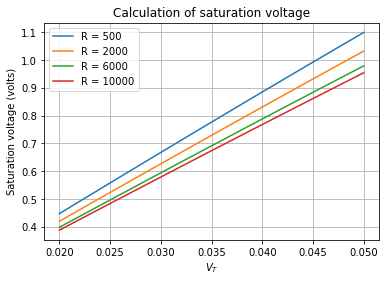

In [44]:
fig, ax = plt.subplots()
ax.set_title('Calculation of saturation voltage')
ax1 = ax
ax1.set_ylabel('Saturation voltage (volts)')
ax1.set_xlabel('$V_T$')
x = np.linspace(0.02, 0.05, 100)

for rval in (500, 2000,6000,10000):
    y = list(map(lambda v: root_scalar(f5, args=(v,rval), bracket=(0,5)).root, x))
    ax1.plot(x,y, label='R = {}'.format(rval))
ax1.grid()
ax1.legend()

LinregressResult(slope=19.362505778884227, intercept=0.012455723437957977, rvalue=0.999987132735787, pvalue=1.0480505254927601e-226, stderr=0.009922264979108298, intercept_stderr=0.0003579607711898176)

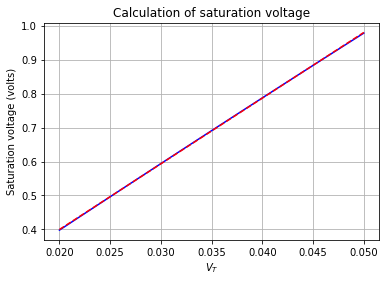

In [45]:
x = np.linspace(0.02, 0.05, 100)
y = list(map(lambda v: root_scalar(f5, args=(v,6000), bracket=(0,1)).root, x))
fig, ax = plt.subplots()

ax.set_title('Calculation of saturation voltage')


ax1 = ax
ax1.set_ylabel('Saturation voltage (volts)')
ax1.set_xlabel('$V_T$')
res = linregress(x,y)
slope = res.slope
intercept = res.intercept
def g(x):
    y =  np.array(x)*slope + intercept
    return y

ax1.plot(x,y,'b-')
ax1.plot(x,g(x),'r--')
ax1.grid()
res

In [46]:
eqn6

-I_{ES}*R*(exp(V_C/V_T) - 1) - V_C + V_{CC}

In [47]:
f6def = eqn6.subs([(r,6800),(vcc,5),])
f6 = lambdify([issym , vc, vt],f6def)
f6def

-6800*I_{ES}*(exp(V_C/V_T) - 1) - V_C + 5

In [48]:
f6(1.6e-8, 0.60, 0.04)

-351.2689813249657

In [49]:
vcval = 0.65
vtval = 0.033
root_scalar(f6, args=(vcval, vtval), bracket=[1.6e-30,1.6e-8], rtol=.01)

#y = list(map(lambda v: root_scalar(f6, args=(v, isval), bracket=[.1,.8], rtol=.1).root, vtval))


      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 1.785233779718639e-12

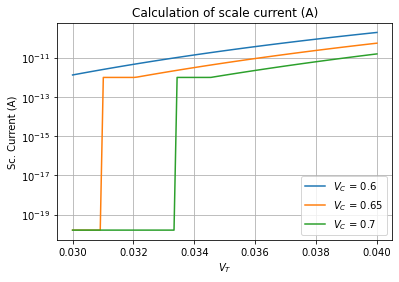

In [50]:
fig, ax = plt.subplots()
ax.set_title('Calculation of scale current (A)')
ax1 = ax
ax1.set_ylabel('Sc. Current (A)')
ax1.set_xlabel('$V_T$')

for vcval in (0.6, 0.65, 0.7): 
    vtval = np.linspace(0.030,0.04,100)
    
    y = np.array(list(map(lambda v: root_scalar(f6, args=(vcval, v), bracket=[1.6e-20,1.6e-8], rtol=.1).root, vtval)))
    ax1.semilogy(vtval,y.tolist(), label='$V_C$ = {}'.format(vcval))
ax1.grid()
ax1.legend()

0.6 0.7


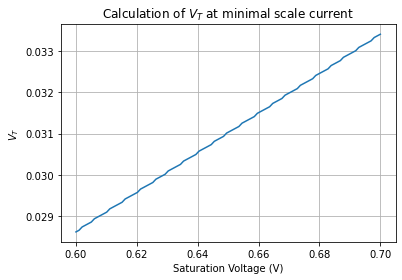

In [51]:
fig, ax2 = plt.subplots(1,1)
ax2.set_title('Calculation of $V_T$ at minimal scale current')
#ax1.set_ylabel('Sc. Current (A)')
ax2.set_ylabel('$V_T$')
#ax1.set_xlabel('Saturation Voltage')
ax2.set_xlabel('Saturation Voltage (V)')

minsc = []
iarr = []
for vcval in np.linspace(0.6, 0.7,100): 
    vtval = np.linspace(0.025,0.045,500)
    
    y = np.array(list(map(lambda v: root_scalar(f6, args=(vcval, v), bracket=[1.6e-20,1.6e-8], rtol=.1).root, vtval)))
    idx = np.argmax(y>1.6e-20)
    
    vt = vtval[idx]
    sc = y[idx]
    iarr.append(idx)
    minsc.append((vcval, vt,sc))
    #ax1.semilogy(vtval,y.tolist(), label='$V_C$ = {}'.format(vcval))#
#ax1.grid()
ax2.grid()
values = np.array(minsc).T

f=interp1d(values[0],values[1], kind='linear')
print (values[0][0], values[0][-1])
x = np.linspace(0.6, 0.7, 1000)
#ax1.legend()
ax2.plot(values[0], values[1])
#ax2.plot(x, f(x))
